In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Import Libraries**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Fraud.csv')
print(df.head(10))

   step      type    amount  ... newbalanceDest  isFraud  isFlaggedFraud
0     1   PAYMENT   9839.64  ...           0.00        0               0
1     1   PAYMENT   1864.28  ...           0.00        0               0
2     1  TRANSFER    181.00  ...           0.00        1               0
3     1  CASH_OUT    181.00  ...           0.00        1               0
4     1   PAYMENT  11668.14  ...           0.00        0               0
5     1   PAYMENT   7817.71  ...           0.00        0               0
6     1   PAYMENT   7107.77  ...           0.00        0               0
7     1   PAYMENT   7861.64  ...           0.00        0               0
8     1   PAYMENT   4024.36  ...           0.00        0               0
9     1     DEBIT   5337.77  ...       40348.79        0               0

[10 rows x 11 columns]


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [ ]:
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [ ]:
df.isnull().sum()

,0
step,0
type,0
amount,0
nameOrig,0
oldbalanceOrg,0
newbalanceOrig,0
nameDest,0
oldbalanceDest,0
newbalanceDest,0
isFraud,0


In [ ]:
print("Duplicates:", df.duplicated().sum())

Duplicates: 0


In [ ]:
fraud_count = df['isFraud'].sum()
print("Total number of fraudulent transactions:", fraud_count)

Total number of fraudulent transactions: 8213


In [ ]:
flagged_count = df['isFlaggedFraud'].sum()
print("Total number of flagged transactions(Transfers which are more than 200.00 in single transaction):", flagged_count)

Total number of flagged transactions(Transfers which are more than 200.00 in single transaction): 16


In [ ]:
fraud_flagged_count = df[(df['isFraud'] == 1) & (df['isFlaggedFraud'] == 1)].shape[0]
print("Total number of transactions which are both flagged and fraudulent:", fraud_flagged_count)

Total number of transactions which are both flagged and fraudulent: 16


# **Exploratory Data Analysis**
---



Text(0, 0.5, 'Count')

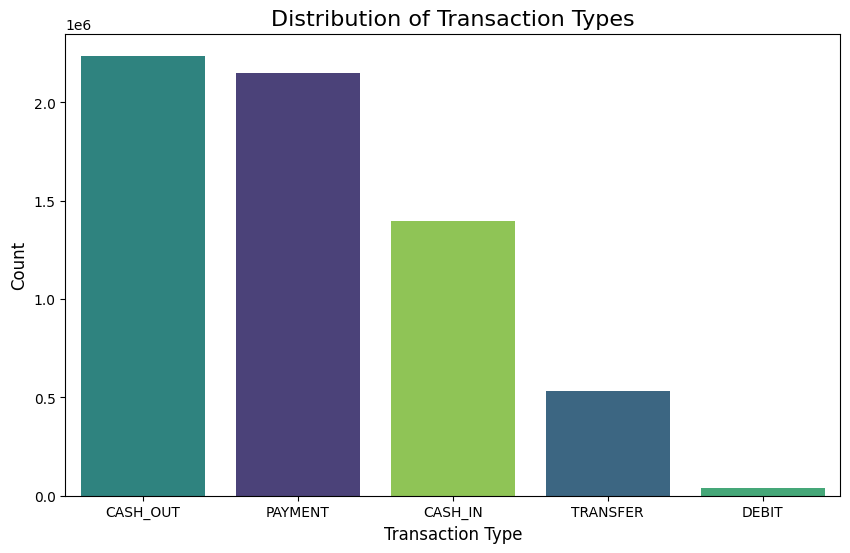

In [ ]:
plt.figure(figsize=(10, 6))
ax = sns.countplot(data=df, x='type', hue='type', order=df['type'].value_counts().index, palette='viridis', legend=False)
plt.title("Distribution of Transaction Types", fontsize=16)
plt.xlabel("Transaction Type", fontsize=12)
plt.ylabel("Count", fontsize=12)

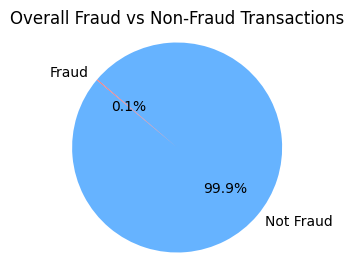

In [ ]:
# Count total fraud and non-fraud
overall_counts = df['isFraud'].value_counts()

# Labels and colors
labels = ['Not Fraud', 'Fraud']
colors = ['#66b3ff', '#ff6666']

# Plot pie chart
plt.figure(figsize=(4, 3))
plt.pie(overall_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
plt.title('Overall Fraud vs Non-Fraud Transactions')
plt.axis('equal')
plt.show()

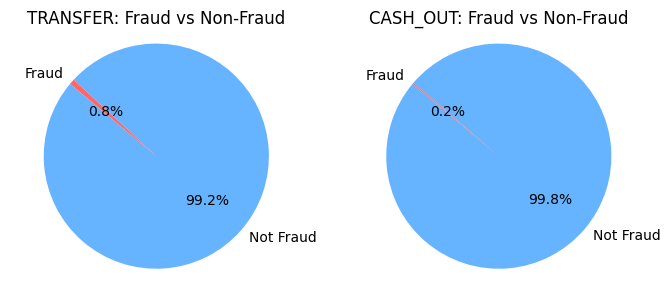

In [ ]:
transfer_df = df[df['type'] == 'TRANSFER']
cashout_df = df[df['type'] == 'CASH_OUT']

# Count fraud and non-fraud
transfer_counts = transfer_df['isFraud'].value_counts()
cashout_counts = cashout_df['isFraud'].value_counts()


labels = ['Not Fraud', 'Fraud']
colors = ['#66b3ff', '#ff6666']

# Plot side-by-side pie charts
fig, axs = plt.subplots(1, 2, figsize=(7, 3))

# TRANSFER pie chart
axs[0].pie(transfer_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
axs[0].axis('equal')
axs[0].set_title('TRANSFER: Fraud vs Non-Fraud')

# CASH_OUT pie chart
axs[1].pie(cashout_counts, labels=labels, autopct='%1.1f%%', startangle=140, colors=colors)
axs[1].axis('equal')
axs[1].set_title('CASH_OUT: Fraud vs Non-Fraud')

plt.tight_layout()
plt.show()

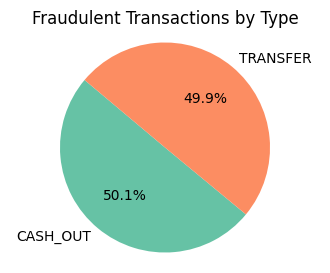

In [ ]:
# Create separate DataFrame for fraudulent transactions
fraud_df = df[df['isFraud'] == 1]

# Count transaction types for fraudulent transactions
fraud_counts = fraud_df['type'].value_counts()

# Set up the pie chart
plt.figure(figsize=(4, 3))
plt.pie(fraud_counts, labels=fraud_counts.index, autopct='%1.1f%%', startangle=140, colors=sns.color_palette("Set2"))
plt.axis('equal')
plt.title('Fraudulent Transactions by Type')

plt.show()

# **Model Building**

In [ ]:
df = df.drop(columns=['isFlaggedFraud', 'nameOrig', 'nameDest'])
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0
2,1,TRANSFER,181.00,181.0,0.00,0.0,0.0,1
3,1,CASH_OUT,181.00,181.0,0.00,21182.0,0.0,1
4,1,PAYMENT,11668.14,41554.0,29885.86,0.0,0.0,0


**Using Xg Boost**

In [ ]:
# Preprocessing
X = df.drop(columns=['isFraud', 'type'])  # Drop target and categorical column
y = df['isFraud']

# Normalize numerical features
scaler = StandardScaler()
X[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']] = scaler.fit_transform(
    X[['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']]
)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate the model
y_pred = xgb_model.predict(X_test)
y_pred

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [10:34:08] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
# Generate classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.94      0.80      0.87      1643

    accuracy                           1.00   1272524
   macro avg       0.97      0.90      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524



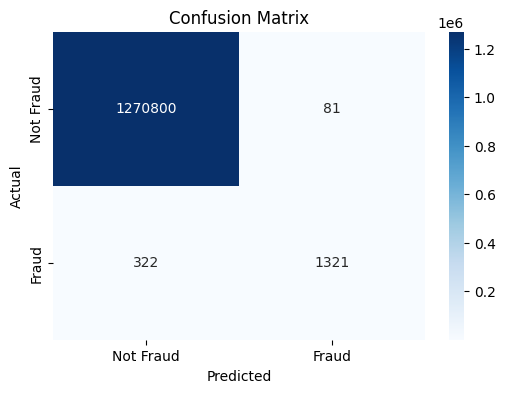

In [ ]:
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)

Model Accuracy: 0.999683306562391


In [ ]:
f1_score(y_test, y_pred)

0.8676518883415435

**Using Logistic Regression Model**

In [ ]:
# Train Logistic Regression model
lr_model = LogisticRegression(random_state=42, max_iter=1000)
lr_model.fit(X_train, y_train)

# Predict using the Logistic Regression model
y_pred_lr = lr_model.predict(X_test)

In [ ]:
# Generate classification report
print(classification_report(y_test, y_pred_lr))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.92      0.42      0.58      1643

    accuracy                           1.00   1272524
   macro avg       0.96      0.71      0.79   1272524
weighted avg       1.00      1.00      1.00   1272524



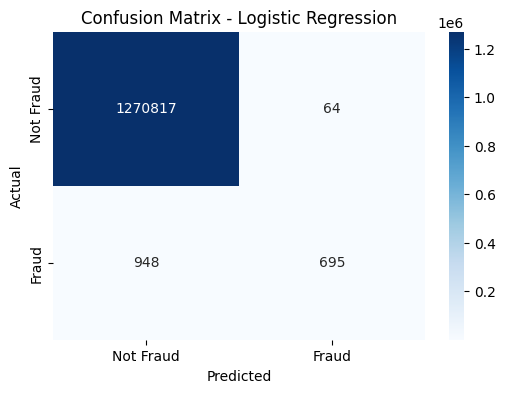

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_lr), annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()

In [ ]:
accuracy_score(y_test, y_pred_lr)

0.9992047301268974

In [ ]:
f1_score(y_test, y_pred_lr)

0.578684429641965

**Using Decision Tree**

In [ ]:
# Train Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Predict using the Decision Tree model
y_pred_dt = dt_model.predict(X_test)

In [ ]:
# Generate classification report
print(classification_report(y_test, y_pred_dt))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1270881
           1       0.87      0.86      0.86      1643

    accuracy                           1.00   1272524
   macro avg       0.93      0.93      0.93   1272524
weighted avg       1.00      1.00      1.00   1272524



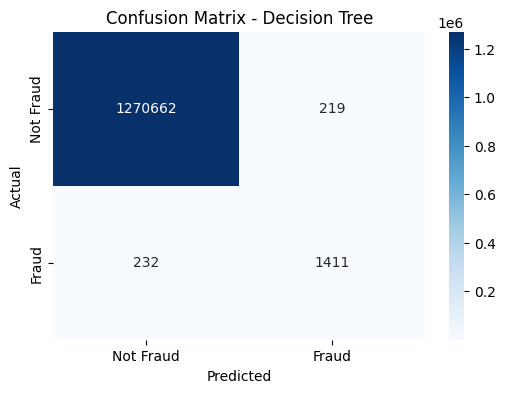

In [ ]:
# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred_dt), annot=True, fmt='d', cmap='Blues', xticklabels=['Not Fraud', 'Fraud'], yticklabels=['Not Fraud', 'Fraud'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

In [ ]:
accuracy_score(y_test, y_pred_dt)

0.9996455862522042

In [ ]:
f1_score(y_test, y_pred_dt)

0.8622059272838375

In [ ]:
results = {
    "Model": ["XGBoost", "Logistic Regression", "Decision Tree"],
    "Accuracy": [
        accuracy_score(y_test, y_pred),
        accuracy_score(y_test, y_pred_lr),
        accuracy_score(y_test, y_pred_dt)
    ],
    "Precision": [
        precision_score(y_test, y_pred),
        precision_score(y_test, y_pred_lr),
        precision_score(y_test, y_pred_dt)
    ],
    "Recall": [
        recall_score(y_test, y_pred),
        recall_score(y_test, y_pred_lr),
        recall_score(y_test, y_pred_dt)
    ],
    "F1-Score": [
        f1_score(y_test, y_pred),
        f1_score(y_test, y_pred_lr),
        f1_score(y_test, y_pred_dt)
    ],
    "ROC-AUC": [
        roc_auc_score(y_test, y_pred),
        roc_auc_score(y_test, y_pred_lr),
        roc_auc_score(y_test, y_pred_dt)
    ]
}

results_df = pd.DataFrame(results)

# Display results
print("Model Comparison Results:")
display(results_df.sort_values(by="F1-Score", ascending=False))


Model Comparison Results:


,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,XGBoost,0.999683,0.942225,0.804017,0.867652,0.901977
2,Decision Tree,0.999646,0.865644,0.858795,0.862206,0.929311
1,Logistic Regression,0.999205,0.915679,0.423007,0.578684,0.711478


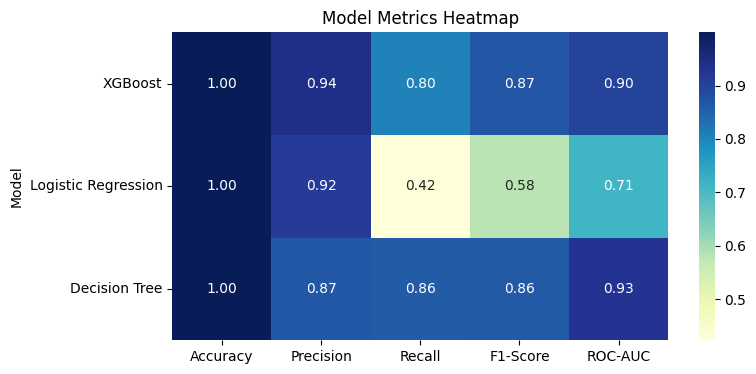

In [ ]:
plt.figure(figsize=(8, 4))
sns.heatmap(results_df.set_index("Model"), annot=True, cmap="YlGnBu", fmt=".2f")
plt.title("Model Metrics Heatmap")
plt.show()

**XGBoost** outperformed both Logistic Regression and Decision Tree in almost every metric F1-Score , Accuracy and Precision which are critical for fraud detection on imbalanced datasets.

## 2. Describe Your Fraud Detection Model in Elaboration

- Built three machine learning models:
  - **Logistic Regression**: A linear model suitable for binary classification tasks.
  - **Decision Tree Classifier**: A non-linear model that splits the data based on feature thresholds, capturing complex transaction patterns.
  - **XGBoost Classifier**: An advanced gradient boosting algorithm that builds an ensemble of decision trees, optimized for performance and robustness. It is highly effective for imbalanced datasets like fraud detection.

- **Final Model Selection**:
  - After evaluating all models using Accuracy,Precision, Recall, F1-Score, and ROC-AUC metrics, **XGBoost** was selected because it had the best result
  



## 3. How Did You Select Variables to be Included in the Model?

- Dropped unnecessary features:
  - nameOrig and nameDest: These are  textual identifiers that do not contribute meaningfully to prediction.
  - isFlaggedFraud: Only captures a very specific condition (large amount), not sufficient alone.

- Final Features Used:
  - amount, oldbalanceOrg, newbalanceOrig, oldbalanceDest, newbalanceDest
  
  - These features directly relate to balance and transaction amounts


## 4. Demonstrate the Performance of the Model by Using Best Set of Tools

Evaluated the models using:
- Accuracy
- Precision
- Recall
- F1-Score
- ROC-AUC Score

**Result**:  
XGBoost outperformed both Logistic Regression and Decision Tree in almost every metric F1-Score , Accuracy and Precision which are critical for fraud detection on imbalanced datasets.


## 5. What Are the Key Factors that Predict Fraudulent Customer?

According to XGBoost feature importance:

- oldbalanceOrg
- amount
- newbalanceOrig
- oldbalanceDest
- newbalanceDest

These features where the key factors that predict Fraudulent Customer

## 6. Do These Factors Make Sense? If Yes, How? If Not, How Not?

Yes, the factors make sense:

- **Large transaction amounts with zero or low old balances**: This suggests unauthorized access.
- **Full draining of account balances**: If an account balance becomes zero, it is suspicious, possibly indicating fraud.
- **Sudden large inflows into destination accounts**: Large inflows into accounts with low prior balances may signal fraudulent or temporary accounts.


## 7. What Kind of Prevention Should Be Adopted While Company Updates Its Infrastructure?

When the company updates its system, it should focus on adding multiple layers of security rather than relying on just one method.

Some practical steps they can take:

- **Real-time fraud detection**: Set up a system that can instantly spot suspicious transactions as they happen, not after the damage is done.

- **Transaction limits**: For new users or accounts that behave differently than usual, it’s safer to have daily or transaction-wise limits until they build a good history.

- **Two-factor authentication**: Before allowing big transactions, customers should be asked to verify using OTPs, apps, or biometric authentication. This step can stop a lot of unauthorized transactions.


- **Extra monitoring for new accounts**: Accounts that are newly created should not be allowed to transfer very large amounts until they have a few verified successful transactions.



## 8. Assuming These Actions Have Been Implemented, How Would You Determine If They Work?

Once all the new fraud prevention measures are in place, we can't just assume they are working. We have to track and measure the impact carefully.

Here’s how I would do it:

- **Monitor the fraud rate**: Check if the number of fraud cases has actually gone down after the changes.
- **Track false positives**: Make sure genuine customers are not being blocked unnecessarily, otherwise it will create new problems.
- **Look at customer complaints**: If fraud complaints reduce over time, that’s a very good sign that things are improving.
- **Measure financial losses**: Compare how much money was lost to fraud before and after the changes.

